In [8]:
from figure_utils import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
SAVE = False
runtime_df = pd.read_parquet(f"{RESULT_DIR}/daic/preprocessed.parquet")
gpu_mapping = {'2080': '2080Ti', '1080': '1080Ti', 'a40': 'A40', 'p100': 'P100', 'v100': 'V100'}
runtime_df = runtime_df[(runtime_df.dataset_type == 'synthetic') & (~runtime_df.operator.isin(['Noop', 'Materialization']))]

runtime_df.compute_unit = runtime_df.compute_unit.astype(str).apply(lambda x: gpu_mapping.get(x, x))
runtime_df['compute_unit'].unique()

array(['CPU 08c', 'CPU 32c', 'CPU 16c', '1080Ti', 'V100', 'P100', 'A40',
       '2080Ti'], dtype=object)

## Data & Model Characteristics

Ideas
 - Complexity ratio vs performance ratio, broken down by X

<Axes: xlabel='comp_ratio', ylabel='speedup'>

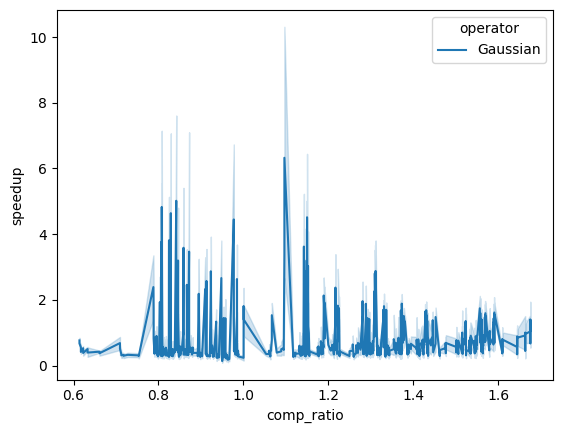

In [9]:
# sns.catplot(data=runtime_df[runtime_df.operator.isin(MODEL_OPERATORS)][:1000], x='comp_ratio', y='speedup', kind='point', col='operator')
sns.lineplot(data=runtime_df[runtime_df.operator =='Gaussian'][:10000], x='comp_ratio', y='speedup', hue='operator')


In [10]:
runtime_df['complexity_rounded'] = runtime_df.complexity_ratio.apply(lambda x: round((x * 2), 0)/2)
runtime_df['TR_rounded'] = runtime_df.TR.apply(lambda x: round((x /4), 0)*2)
runtime_df['FR_rounded'] = runtime_df.FR.apply(lambda x: round((x *2), 0)/2)
runtime_df['speedup_rounded'] = runtime_df.speedup.apply(lambda x: round(x / 10, 0) * 10).clip(upper=3)

In [11]:
runtime_df.columns

Index(['dataset', 'speedup', 'operator', 'num_cores', 'selectivity',
       'cardinality_T', 'cardinality_S', 'join', 'compute_unit',
       'complexity_ratio', 'times_mean', 'source_file', 'dataset_type',
       'compute_type', 'label', 'features', 'parallelism', 'mem_mat_read',
       'mem_mat_write', 'mem_fac_read', 'mem_fac_write', 'comp_scalar_mat',
       'comp_lmm_mat', 'comp_rmm_mat', 'comp_scalar_fac', 'comp_lmm_fac',
       'comp_rmm_fac', 'comp_mat_col_major', 'comp_fac_col_major',
       'comp_scalar_dense', '13', '14', 'comp_matrix_dense',
       'mem_read_scalar_dense', 'mem_write_scalar_dense',
       'mem_read_matrix_dense', 'mem_write_matrix_dense', 'mem_read_rowsum',
       'mem_write_rowsum', 'mem_read_colsum', 'mem_write_colsum', '24', '25',
       'comp_rowsum', 'comp_colsum', 'comp_mat', 'comp_fac', 'comp_ratio',
       'tr', 'fr', 'r_S', 'c_S', 'TR', 'FR', 'nnz_T', 'nnz_S_sum', 'nnz_S',
       'r_T', 'c_T', 'sparsity_T', 'sparsity_S', 'morpheusfi_p',
       'morp

## Hardware Characteristics

In [12]:
from io import StringIO


df = pd.read_csv("./tables/gpu-metrics/gpu-metrics.tsv", delimiter="\t", thousands=",")

df.fillna("", inplace=True)
df["characteristic"] = df.apply(
    lambda row: row["Group"].lower().replace(" ", "_") + "." + row["Characteristic"].lower().replace(" ", "_"), axis=1
).apply(lambda x: x[1:] if x.startswith(".") else x)
df.drop(columns=["Group", "Characteristic", "Unit"], inplace=True)
df = df.T
df.columns = df.tail(1).values[0]
df = df[:-1]
df.index.name = "GPU"
gpu_chars = pd.read_csv(StringIO(df.to_csv()), thousands=",")
gpu_chars.GPU = gpu_chars.GPU.astype(str)
gpu_chars

gpu_df = runtime_df.merge(gpu_chars, left_on="compute_unit", right_on="GPU")

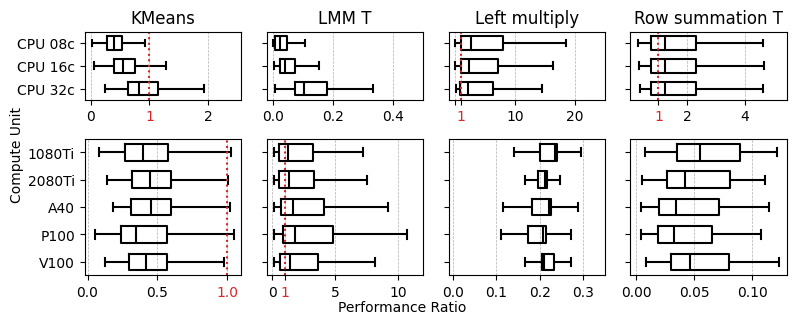

In [13]:
df = runtime_df[runtime_df.dataset_type == "synthetic"]
df = df[~df.operator.isin(["Noop", "Materialization"])]
operators = ["LMM T", "Left multiply", 'Row summation T', "KMeans"]
df.sort_values(by='compute_unit', ascending=True, inplace=True)

fig, axes = plt.subplots(2, len(operators), figsize=(FIGURE_WIDTH_INCHES, FIGURE_WIDTH_INCHES/2.5), sharex=False, sharey='row', gridspec_kw={'height_ratios': [1, 2]})

fig.text(0.5, 0.01, 'Performance Ratio', ha='center')
fig.text(0.01, 0.5, 'Compute Unit', va='center', rotation='vertical')

kwargs = dict(
    x="speedup",
    y="compute_unit",
    fill=False,
    fliersize=0,
    color="black",
    width=0.6,
)

for axs, (compute_type, sub_df) in zip(axes, df[df.operator.isin(operators)].groupby("compute_type")):        
    for ax, (operator, ssub_df) in zip(axs, sub_df.groupby("operator")):
        sns.boxplot(
            data=ssub_df,
            ax=ax,
            **kwargs
        )

        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.grid(True, axis='x', linestyle='--', linewidth=0.5)
        ax.axvline(1.0, linestyle='dotted', color='tab:red')
        ax.set_axisbelow(True)

        if compute_type == "cpu":
            ax.set_title(operator)
            
            if operator == "LMM T":
                ax.set_xlim((-0.02, 0.5))
                
            if operator == "Left multiply":
                ax.set_xlim((-1., 25))
                ax.set_xticks([0, 1, 10, 20])
                ax.set_xticklabels(['','1','10','20'])
                ax.get_xticklabels()[1].set_color('tab:red')
                
            if operator == "KMeans":
                ax.get_xticklabels()[2].set_color('tab:red')
                
            if operator == "Row summation T":
                ax.set_xticks([1, 2, 4])
                ax.get_xticklabels()[0].set_color('tab:red')
                
        if compute_type == "gpu":
            if operator == "Left multiply":
                ax.set_xticks([0.0, 0.1, 0.2, 0.3])
                ax.set_xlim(-0.01, 0.35)
        
            if operator == "KMeans": 
                ax.set_xlim(-0.02, 1.1)
                ax.get_xticklabels()[3].set_color('tab:red')
            
            if operator == "LMM T":
                ax.set_xticks([0, 1, 5, 10])
                ax.get_xticklabels()[1].set_color('tab:red')
            
            if operator == "Row summation T":
                ax.set_xlim(-0.005, 0.13)

plt.tight_layout()
if SAVE or False:
    fig.savefig(f"{LATEX_PROJECT_BASE_PATH}/chapters/05_cost_estimation/figures/motivation_speedup_per_operator_per_gpu.pdf", bbox_inches="tight")

In [14]:
avg_speedup_df = df[(df.label & df.operator.isin(MODEL_OPERATORS))].groupby(["compute_unit"]).agg({"speedup": ["mean", "count", "std"]})
avg_speedup_df = avg_speedup_df.reindex(columns=[("speedup", "mean"), ("speedup", "std"), ("speedup", "count")]).speedup.reset_index()
avg_speedup_df['pct_with_speedup'] = (avg_speedup_df['count'] / 9660 * 100).apply(lambda x: f"{x:.2f}\%")
avg_speedup_df = avg_speedup_df.reindex(index=[3,4,5,0,1,2,6,7])
display(avg_speedup_df)
table = (
    avg_speedup_df.to_latex(float_format="%.2f", index=False)
    .replace("{lrrrl}", "{lrrrr}")
    .replace(" & \multicolumn{3}{r}{speedup} \\\n", "")
    .replace("mean", "Mean")
    .replace("std", "Std. Dev.")
    .replace("count", "Count")
    .replace("compute_unit", "Compute Unit")
    .replace("\midrule", "\midrule\midrule")
    .replace("pct_with_speedup", "\% with Speedup")
)
if SAVE or False:
    save_table(table, "chapters/05_cost_estimation/figures/speedup_per_gpu.tex")

,compute_unit,mean,std,count,pct_with_speedup
3,CPU 08c,1.268460,0.245277,172,1.78\%
4,CPU 16c,1.320765,0.344375,579,5.99\%
5,CPU 32c,1.476503,0.462475,2873,29.74\%
0,1080Ti,2.269407,1.599944,432,4.47\%
1,2080Ti,1.867994,1.090409,425,4.40\%
2,A40,2.004561,1.198363,392,4.06\%
6,P100,2.519784,1.836018,461,4.77\%
7,V100,1.945979,1.126639,404,4.18\%


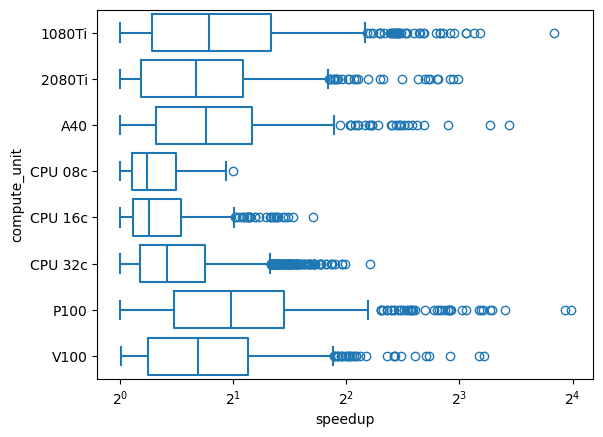

In [15]:
avg_speedup_df = avg_speedup_df.reindex(index=[3,4,5,0,1,2,6,7])
ax = sns.boxplot(df[(df.label & df.operator.isin(MODEL_OPERATORS))], y='compute_unit', x='speedup', 
            # errorbar='sd', 
            fill = None,
            # color="black",
            # hue='operator',
            )
ax.set_xscale('log', base=2)

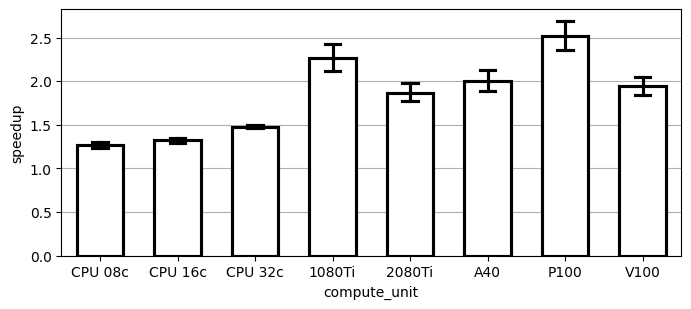

In [16]:
from operator import itemgetter
itemgetter = itemgetter(*[3,4,5,0,1,2,6,7])

fig, ax = plt.subplots(1,1, figsize=(FIGURE_WIDTH_INCHES, FIGURE_WIDTH_INCHES/2.5))

ax = sns.barplot(df[(df.label & df.operator.isin(MODEL_OPERATORS))], x='compute_unit', y='speedup', 
            errorbar='ci', 
            capsize=0.2,
            n_boot=5_000,
            order=itemgetter(df.compute_unit.unique()),
            fill = None, 
            facecolor='white', 
            edgecolor='black',
            err_kws={'color': 'black'},
            # hue='compute_type',
            width=0.6,
            )
ax.grid(axis='y')
ax.set_axisbelow(True)


# sns.stripplot(df[(df.label & df.operator.isin(MODEL_OPERATORS))], x='compute_unit', y='speedup', ax=ax, size=1, hue='operator')

In [17]:
avg_speedup_df_operator = df[(df.operator.isin(["LMM T", "Left multiply", "Row summation T"])) & (df.compute_unit.isin(["V100", "P100"]))].groupby(["compute_unit", 'operator']).agg({"speedup": ["mean", "count", "std"]})
display(avg_speedup_df_operator.round(2))

speedup            
                                mean count   std
compute_unit operator                           
P100         LMM T              3.03  2415  2.70
             Left multiply      0.19  2415  0.05
             Row summation T    0.04  2415  0.03
V100         LMM T              2.33  2415  2.21
             Left multiply      0.21  2415  0.04
             Row summation T    0.05  2415  0.03

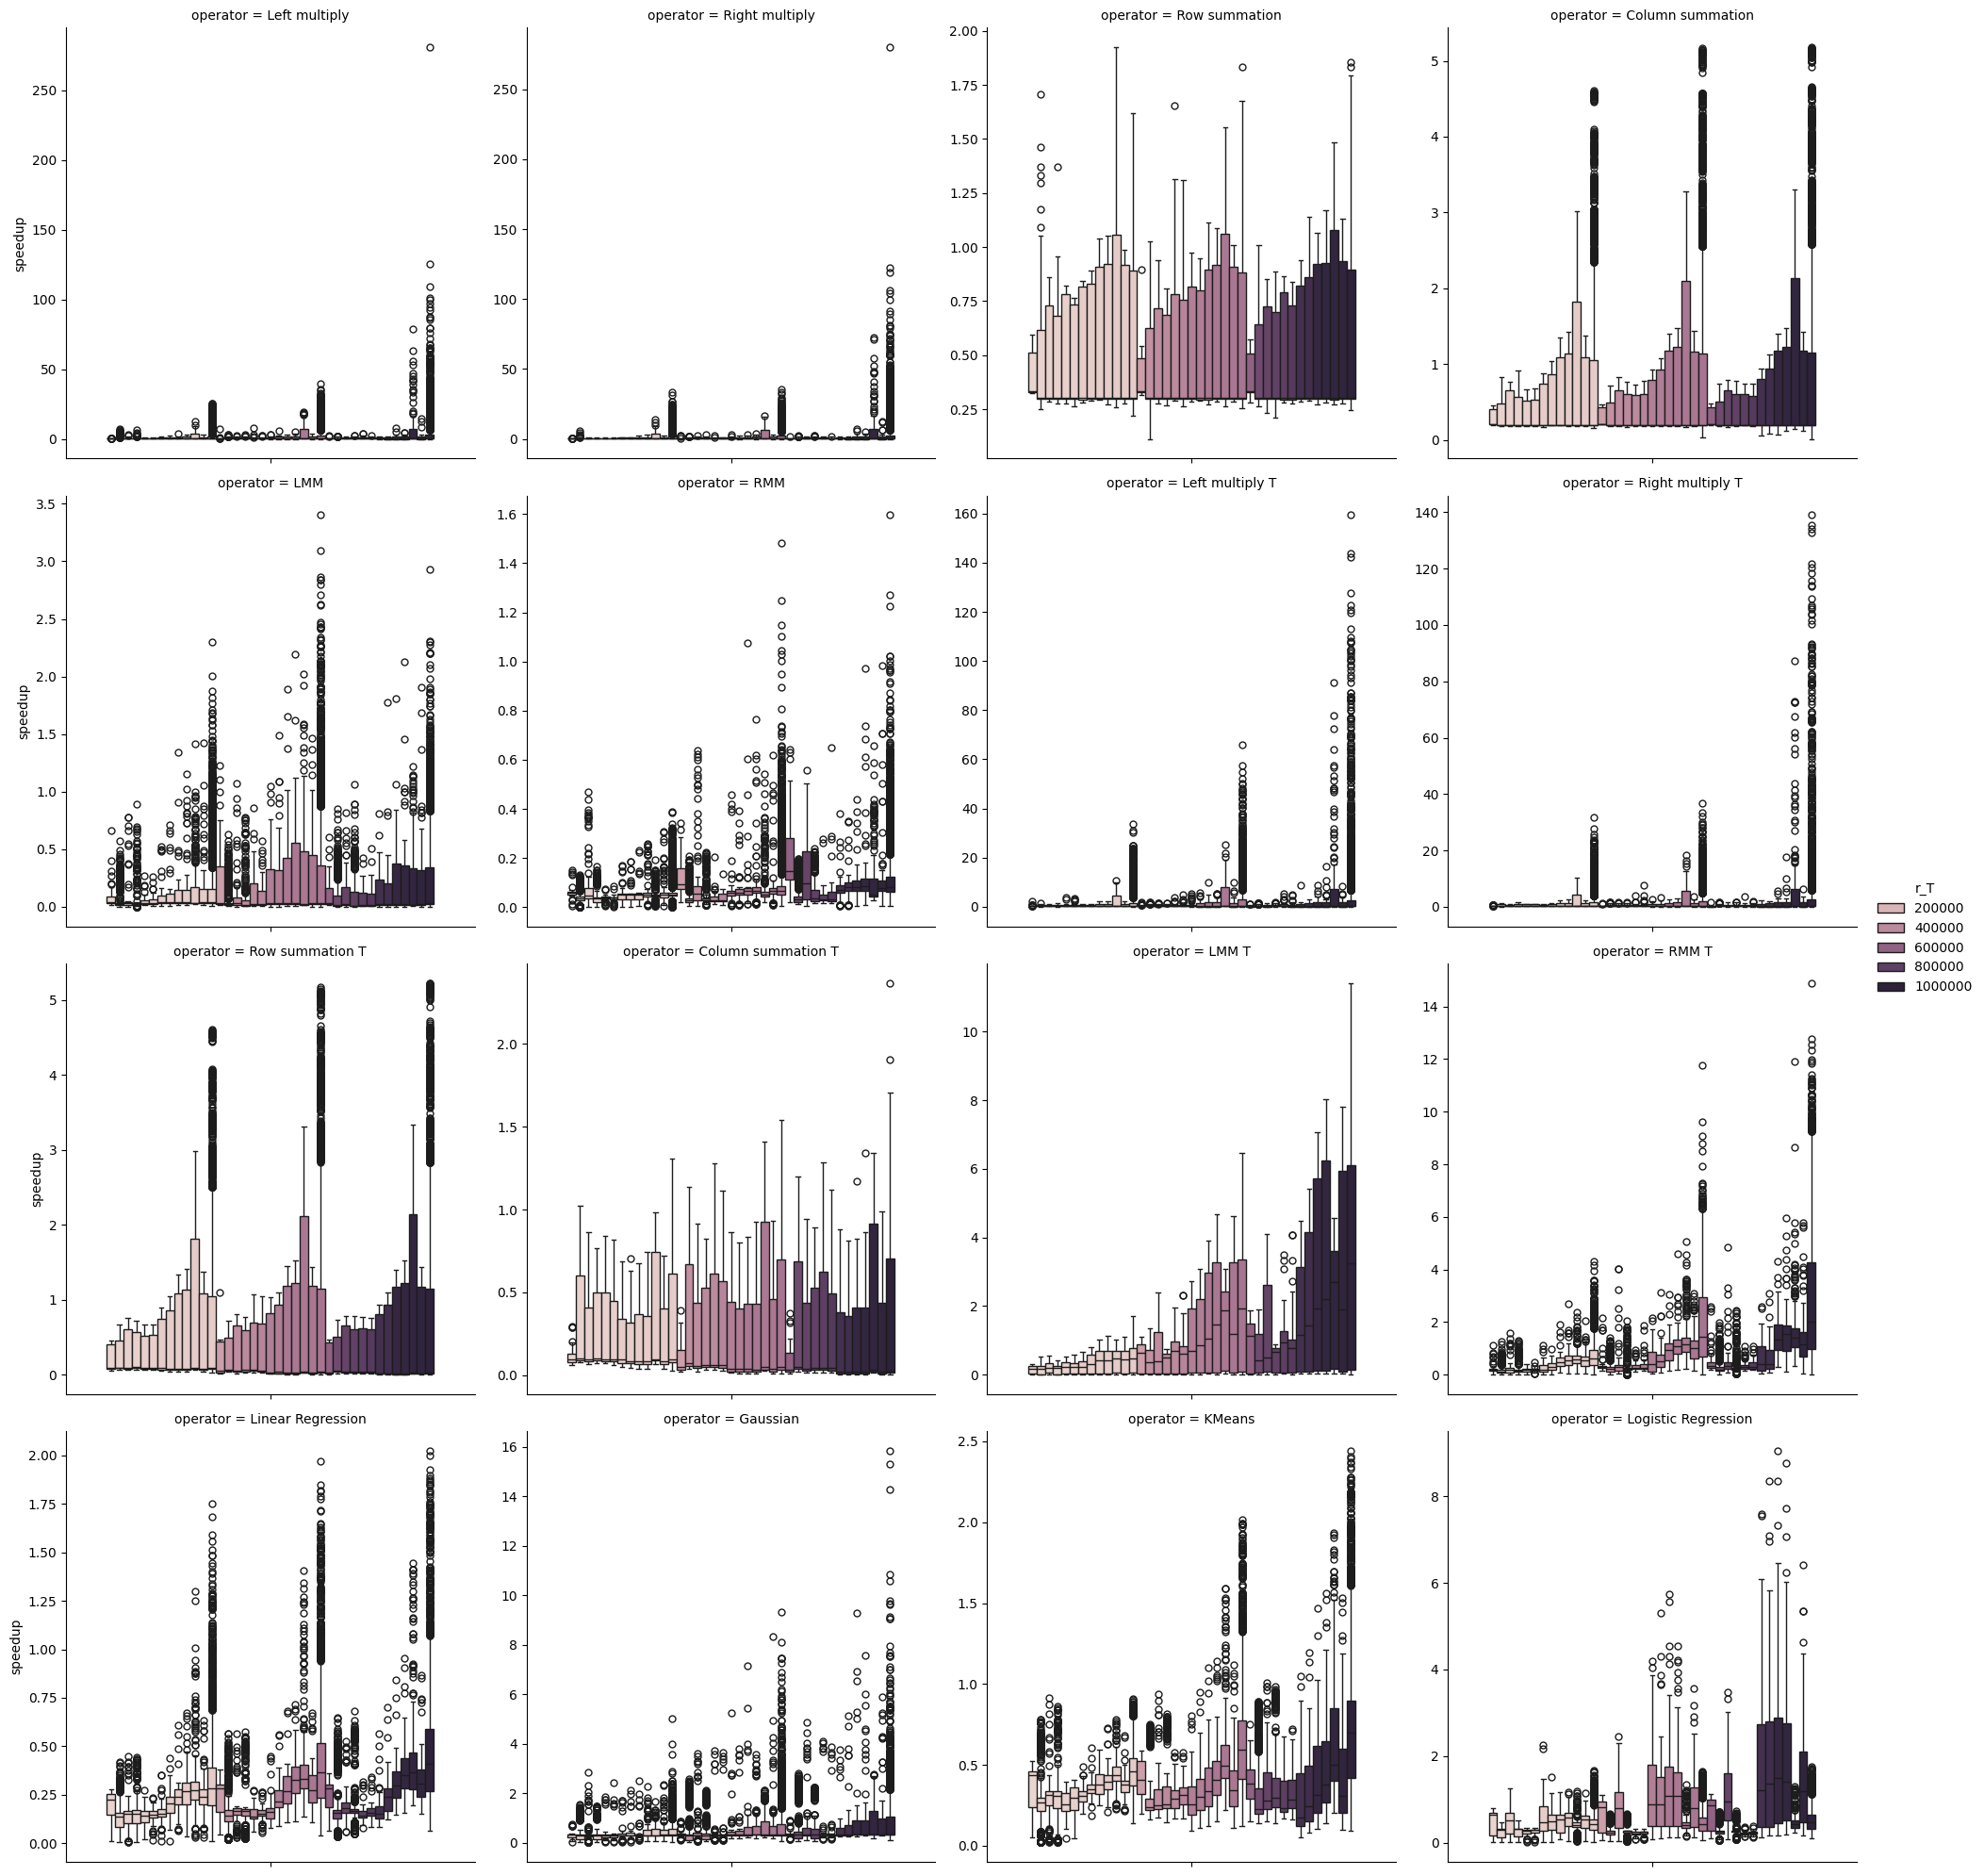

In [21]:
sns.catplot(data=runtime_df, y='speedup', hue='r_T', col='operator', kind='box', sharey=False, col_wrap=4)